In [ ]:
%pip install velo-sdk seaborn matplotlib numpy --quiet

In [2]:
# Relay Colab secret to os.environ to keep the core logic vendor free
try:
    import os
    from google.colab import auth, userdata
    auth.authenticate_user()

    os.environ["RISKTHINKING_API_KEY"] = userdata.get("RISKTHINKING_API_KEY")
except Exception:
    # likely not in Google Colab, ignore and move on
    pass

In [3]:
# Time horizons to compare
HORIZONS = [2030, 2050, 2070, 2090]

In [4]:
# Search for the companies to compare
from velo_sdk.api import APIClient
import polars as pl

client = APIClient()  # VELO SDK auto detects $RISKTHINKING_API_KEY env var

results = client.companies.search_companies(name="Microsoft")
microsoft_company_id = results[0].id

results = client.markets.search_indexes(name="S&P 500")
sp500_market_id = results[0].id

In [5]:
# Load climate scores for analysis
dataframes = []

for horizon in HORIZONS:
    dataframes.append(
        client.companies.aggregate_company_asset_climate_scores_by_country(
            microsoft_company_id, "SV", horizon
        )
        .to_polars()
        .with_columns(
            pl.lit(horizon).alias("horizon"), pl.lit("Microsoft").alias("entity")
        )
    )
    dataframes.append(
        client.markets.aggregate_index_asset_climate_scores_by_country(
            sp500_market_id, "SV", horizon
        )
        .to_polars()
        .with_columns(
            pl.lit(horizon).alias("horizon"), pl.lit("S&P 500").alias("entity")
        )
    )

analysis_df = pl.concat(dataframes)

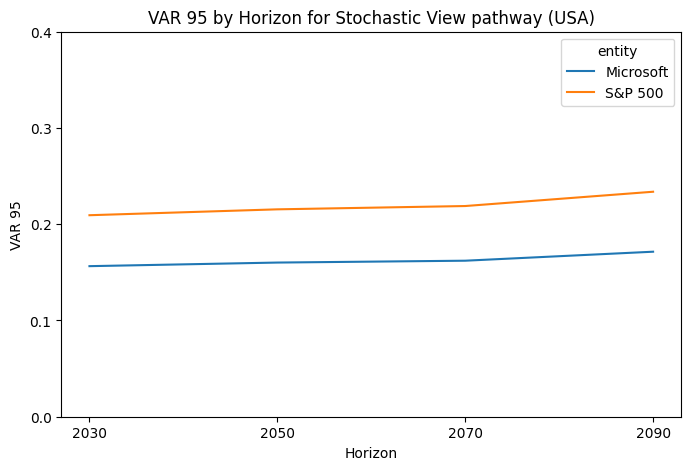

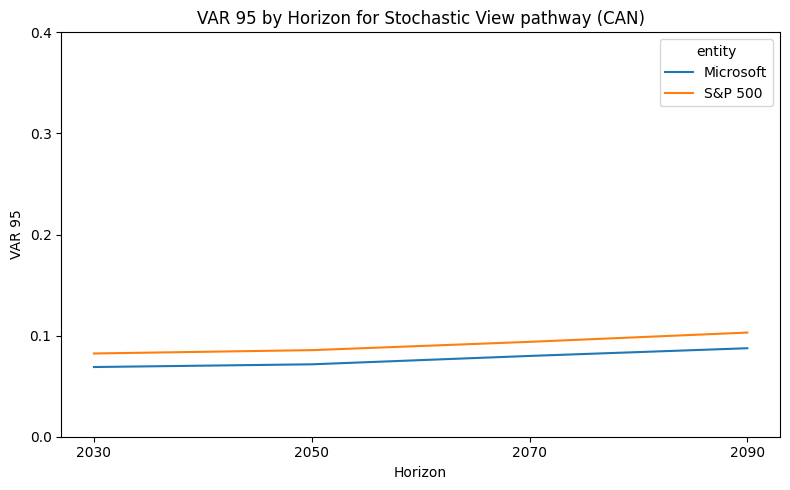

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compare value at risk across countries
for country in ["USA", "CAN"]:
    country_df = analysis_df.filter(pl.col("country") == country)
    fig, ax = plt.subplots(figsize=(8, 5)) 
    sns.lineplot(x="horizon", y="var_95", data=country_df, hue="entity", ax=ax)
    ax.set_title(f"VAR 95 by Horizon for Stochastic View pathway ({country})")
    ax.set_xlabel("Horizon")
    ax.set_ylabel("VAR 95")
    ax.set_xticks(ticks=HORIZONS)
    ax.set_yticks(ticks=np.arange(0, 0.5, step=0.1))
plt.tight_layout()
plt.show()

In [7]:
# Load risk factor impacts for analysis
dataframes = []

for horizon in HORIZONS:
    dataframes.append(
        client.companies.aggregate_company_asset_impact_scores_by_country(
            microsoft_company_id, "SV", horizon
        )
        .to_polars()
        .with_columns(
            pl.lit(horizon).alias("horizon"), pl.lit("Microsoft").alias("entity")
        )
    )
    dataframes.append(
        client.markets.aggregate_index_asset_impact_scores_by_country(
            sp500_market_id, "SV", horizon
        )
        .to_polars()
        .with_columns(
            pl.lit(horizon).alias("horizon"), pl.lit("S&P 500").alias("entity")
        )
    )

analysis_df: pl.DataFrame = pl.concat(dataframes)


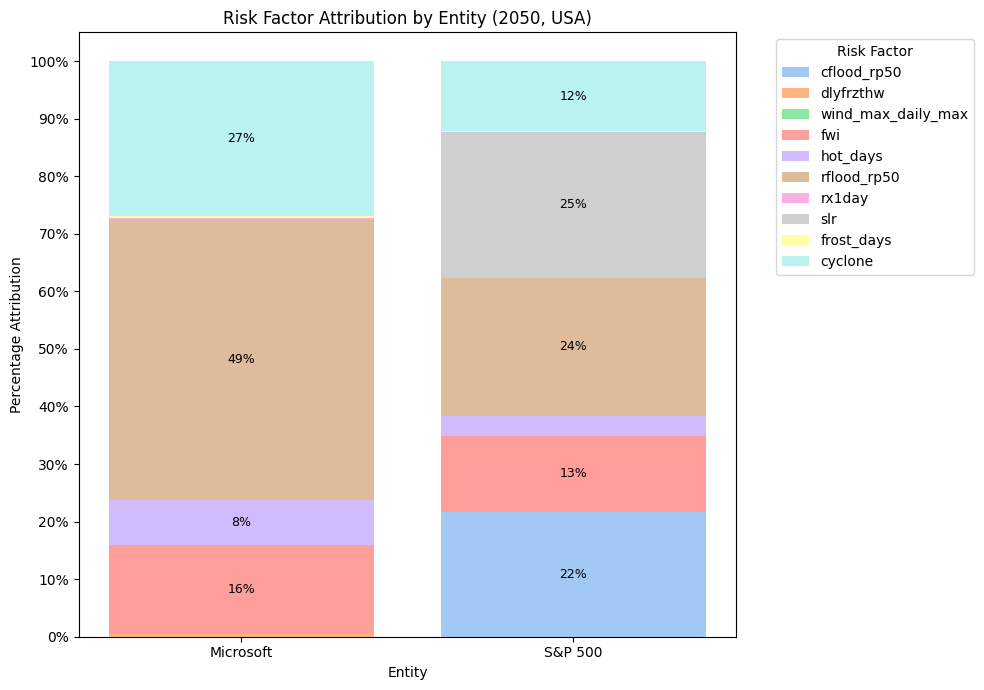

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Risk factor attribution for the future 2050 horizon in the USA
pivot_df = (
    analysis_df.filter((pl.col("horizon") == 2050) & (pl.col("country") == "USA"))
    .pivot(on="index_name", index="entity", values="index_attribution_expected")
    .fill_null(0)
)

risk_factors = set(pivot_df.columns) - {"entity"}
num_risk_factors = len(risk_factors)
num_entities = len(pivot_df)
colors = sns.color_palette("pastel", num_risk_factors)

fig, ax = plt.subplots(figsize=(10, 7))

bar_width = 0.8  # Width of the bars
company_positions = np.arange(num_entities)

# Keep track of the bottom of the next bar segment to stack
bottoms = np.zeros(num_entities)

for i, factor in enumerate(risk_factors):
    values = pivot_df.get_column(factor)  # Get values for the current risk factor
    bars = ax.bar(
        company_positions,
        values,
        bar_width,
        label=factor,
        bottom=bottoms,
        color=colors[i],
    )
    bottoms += (
        values.to_numpy()
    )  # Add the height of the current bar to the bottom for the next stack

    for bar_idx, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0.05:
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                bottoms[bar_idx] - height / 2.0,  # Center text in the segment
                f"{height:.0%}",
                ha="center",
                va="center",
                fontsize=9,
                color="black",
            )


ax.set_title("Risk Factor Attribution by Entity (2050, USA)")
ax.set_xticks(company_positions)
ax.set_xticklabels(pivot_df.get_column("entity"))
ax.set_xlabel("Entity")
ax.set_ylabel("Percentage Attribution")
ax.set_yticks(np.arange(0, 1.1, 0.1))  # Y-ticks from 0 to 1 (0% to 100%)
ax.set_yticklabels([f"{y:.0%}" for y in np.arange(0, 1.1, 0.1)])
ax.legend(title="Risk Factor", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()